# Data Preparation for Machine Learning


## 1- Data Cleaning
    1- Marking empty values as missing and imputing missing values using statistics or a learned model.(impute NAs)
    2- Identifying duplicate rows of data and removing them.(redundant samples)
    3- Identifying columns that have the same value or no variance and removing them.(redundant features)
    4- Using statistics to define normal data and identify outliers.(Extreme values)

### 1-1- Statistical Imputation for Missing Values in Machine Learning

- Common statistics calculated include:

    - The column mean value.
    - The column median value.
    - The column mode value.
    - A constant value.
    
- The scikit-learn machine learning library provides the SimpleImputer class that supports statistical imputation.

- It is a good practice to evaluate machine learning models on a dataset using k-fold cross-validation.

- To correctly apply statistical missing data imputation and avoid data leakage, it is required that the statistics calculated for each column are calculated on the training dataset only, then applied to the train and test sets for each fold in the dataset.

- (use train mean for that. You should never infer information from test dataset as that's an information leak. Calculating mean of test dataset would give your algoritm info about mean of it (obviously) and would probably falsely improve its score on said.)

- If we are using resampling to select tuning parameter values or to estimate performance, the imputation should be incorporated within the resampling.

- This can be achieved by creating a modeling pipeline where the first step is the statistical imputation, then the second step is the model. This can be achieved using the Pipeline class.

- We can design an experiment to test each statistical strategy and discover what works best for this dataset, comparing the mean, median, mode (most frequent), and constant (0) strategies. The mean accuracy of each approach can then be compared.

#### Horse Colic Dataset

- The horse colic dataset describes medical characteristics of horses with colic and whether they lived or died.

- There are 300 rows and 26 input variables with one output variable. It is a binary classification prediction task that involves predicting 1 if the horse lived and 2 if the horse died.    

>mean 0.861 (0.052)
>median 0.862 (0.051)
>most_frequent 0.862 (0.056)
>constant 0.880 (0.051)


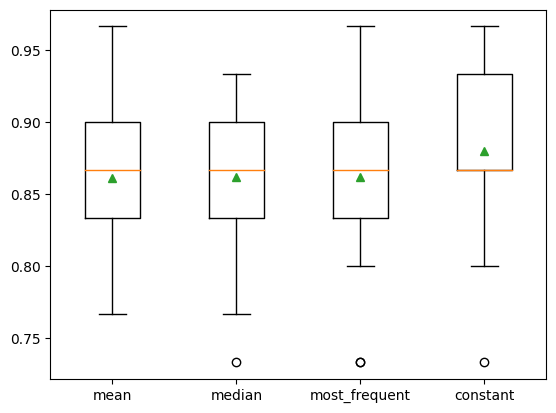

In [17]:
# compare statistical imputation strategies for the horse colic dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
# load dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/horse-colic.csv'
dataframe = read_csv(url, header=None, na_values='?')
# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# evaluate each strategy on the dataset
results = list()
strategies = ['mean', 'median', 'most_frequent', 'constant']
for s in strategies:
	# create the modeling pipeline
	pipeline = Pipeline(steps=[('i', SimpleImputer(strategy=s)), ('m', RandomForestClassifier())])
	# evaluate the model
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	# store results
	results.append(scores)
	print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True)
pyplot.show()

- We may wish to create a final modeling pipeline with the constant imputation strategy and random forest algorithm, then make a prediction for new data.

- This can be achieved by defining the pipeline and fitting it on all available data, then calling the predict() function passing new data in as an argument.

- Importantly, the row of new data must mark any missing values using the NaN value.


In [23]:
from numpy import nan

# create the modeling pipeline
pipeline = Pipeline(steps=[('i', SimpleImputer(strategy='constant')), ('m', RandomForestClassifier())])
# fit the model
pipeline.fit(X, y)

# define new data
row = [2, 1, 530101, 38.50, 66, 28, 3, 3, nan, 2, 5, 4, 4, nan, nan, nan, 3, 5, 45.00, 8.40, nan, nan, 2, 11300, 00000, 00000, 2]
# make a prediction
yhat = pipeline.predict([row])
print('Predicted Class: %d' % yhat[0])

Predicted Class: 2


#### Without pipline

In [29]:
imputer = SimpleImputer(strategy="mean")
# Fit the imputer to the data and transform the data
Xtrans = imputer.fit_transform(X)
Xtrans

array([[2.00000e+00, 1.00000e+00, 5.30101e+05, ..., 0.00000e+00,
        0.00000e+00, 2.00000e+00],
       [1.00000e+00, 1.00000e+00, 5.34817e+05, ..., 0.00000e+00,
        0.00000e+00, 2.00000e+00],
       [2.00000e+00, 1.00000e+00, 5.30334e+05, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       ...,
       [1.00000e+00, 1.00000e+00, 5.29386e+05, ..., 0.00000e+00,
        0.00000e+00, 2.00000e+00],
       [1.00000e+00, 1.00000e+00, 5.30612e+05, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [1.00000e+00, 1.00000e+00, 5.34618e+05, ..., 0.00000e+00,
        0.00000e+00, 2.00000e+00]])

### 1-2- Identifying duplicate rows of data and removing them.(redundant samples)

- From an algorithm evaluation perspective, duplicate rows will result in misleading performance. For example, if you are using a train/test split or k-fold cross-validation, then it is possible for a duplicate row or rows to appear in both train and test datasets and any evaluation of the model on these rows will be (or should be) correct. This will result in an optimistically biased estimate of performance on unseen data.

In [38]:
# locate rows of duplicate data
from pandas import read_csv
# define the location of the dataset
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv'
# load the dataset
df = read_csv(path, header=None)
# calculate duplicates
dups = df.duplicated()
# report if there are any duplicates
print(any(dups))
# list all duplicate rows
print(df[dups])
print(df.shape)
# delete duplicate rows
df.drop_duplicates(inplace=True)
print(df.shape)


True
       0    1    2    3               4
34   4.9  3.1  1.5  0.1     Iris-setosa
37   4.9  3.1  1.5  0.1     Iris-setosa
142  5.8  2.7  5.1  1.9  Iris-virginica
(150, 5)
(147, 5)


### 1-3- Identifying columns that have the same value or no variance and removing them.(redundant features)

- Columns that have a single observation or value are probably useless for modeling.

- These columns or predictors are referred to zero-variance predictors as if we measured the variance (average value from the mean), it would be zero.

- One approach is to record all columns that have a single unique value, then delete them from the Pandas DataFrame by calling the drop() function.

- The example below loads the oil-spill classification dataset that contains 50 variables and summarizes the number of unique values for each column.

In [44]:
# delete columns with a single unique value
from pandas import read_csv
# define the location of the dataset
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/oil-spill.csv'
# load the dataset
df = read_csv(path, header=None)
print(df.shape)
# get number of unique values for each column
counts = df.nunique()
#print(counts)
# record columns to delete
to_del = [i for i,v in enumerate(counts) if v == 1 ]
print(to_del)
# drop useless columns
df.drop(to_del, axis = 1, inplace=True)
print(df.shape)



(937, 50)
[22]
(937, 49)


- near-zero variance predictors or have the potential to have near zero variance during the resampling process. These are predictors that have few unique values (such as two values for binary dummy variables) and occur infrequently in the data.

- Depending on the choice of data preparation and modeling algorithms, variables with very few numerical values can also cause errors or unexpected results. For example, I have seen them cause errors when using power transforms for data preparation and when fitting linear models that assume a “sensible” data probability distribution.

- This does not mean that these rows and columns should be deleted, but they require further attention.

- For example:

    - Perhaps the unique values can be encoded as ordinal values?
    - Perhaps the unique values can be encoded as categorical values?
    - Perhaps compare model skill with each variable removed from the dataset?
 
- Another approach to the problem of removing columns with few unique values is to consider the variance of the column.

- The VarianceThreshold class from the scikit-learn library supports this as a type of feature selection. An instance of the class can be created specify the “threshold” argument, which defaults to 0.0 to remove columns with a single value.
    

(937, 49) (937,)
>Threshold=0.00, Features=48
>Threshold=0.05, Features=37
>Threshold=0.10, Features=36
>Threshold=0.15, Features=35
>Threshold=0.20, Features=35
>Threshold=0.25, Features=35
>Threshold=0.30, Features=35
>Threshold=0.35, Features=35
>Threshold=0.40, Features=35
>Threshold=0.45, Features=33
>Threshold=0.50, Features=31


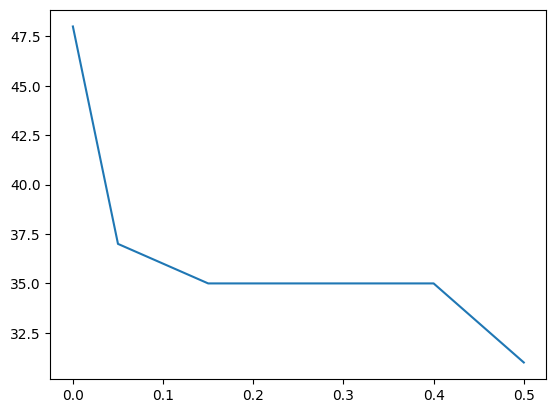

In [51]:
# explore the effect of the variance thresholds on the number of selected features
from numpy import arange
from pandas import read_csv
from sklearn.feature_selection import VarianceThreshold
from matplotlib import pyplot
# define the location of the dataset
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/oil-spill.csv'
# load the dataset
df = read_csv(path, header=None)
# split data into inputs and outputs
data = df.values
X = data[:, :-1]
y = data[:, -1]
print(X.shape, y.shape)
# define thresholds to check
thresholds = arange(0.0, 0.55, 0.05)
# apply transform with each threshold
results = list()
for t in thresholds:
	# define the transform
	transform = VarianceThreshold(threshold=t)
	# transform the input data
	X_sel = transform.fit_transform(X)
	# determine the number of input features
	n_features = X_sel.shape[1]
	print('>Threshold=%.2f, Features=%d' % (t, n_features))
	# store the result
	results.append(n_features)
# plot the threshold vs the number of selected features
pyplot.plot(thresholds, results)
pyplot.show()

- We can see that the number of features in the dataset quickly drops from 49 in the unchanged data down to 35 with a threshold of 0.15. It later drops to 31 (18 columns deleted) with a threshold of 0.5.

- We can see that even with a small threshold between 0.15 and 0.4, that a large number of features (14) are removed immediately.

###   1-4- Using statistics to define normal data and identify outliers.(Extreme values)

Outliers can have many causes, such as:

    - Measurement or input error.
    - Data corruption.
    - True outlier observation (e.g. Michael Jordan in basketball).
    
- This does not mean that the values identified are outliers and should be removed. But, the tools described in this tutorial can be helpful in shedding light on rare events that may require a second look.

- A good tip is to consider plotting the identified outlier values, perhaps in the context of non-outlier values to see if there are any systematic relationship or pattern to the outliers. If there is, perhaps they are not outliers and can be explained, or perhaps the outliers themselves can be identified more systematically.

- If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers.

- Three standard deviations from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution.

- For smaller samples of data, perhaps a value of 2 standard deviations (95%) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9%) can be used.    


### Test Dataset

- We will generate a population 10,000 random numbers drawn from a Gaussian distribution with a mean of 50 and a standard deviation of 5.

- Numbers drawn from a Gaussian distribution will have outliers. That is, by virtue of the distribution itself, there will be a few values that will be a long way from the mean, rare values that we can identify as outliers.

In [55]:
# identify outliers with standard deviation
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(10000) + 50
# calculate summary statistics
data_mean, data_std = mean(data), std(data)
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
# identify outliers
outliers = [x for x in data if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in data if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Identified outliers: 29
Non-outlier observations: 9971


- Not all data is normal or normal enough to treat it as being drawn from a Gaussian distribution.

- A good statistic for summarizing a non-Gaussian distribution sample of data is the Interquartile Range, or IQR for short.

- The IQR is calculated as the difference between the 75th and the 25th percentiles of the data and defines the box in a box and whisker plot.

- The IQR can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is the value 1.5. A factor k of 3 or more can be used to identify values that are extreme outliers or “far outs” when described in the context of box and whisker plots.

In [56]:
# identify outliers with interquartile range
from numpy.random import seed
from numpy.random import randn
from numpy import percentile
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(10000) + 50
# calculate interquartile range
q25, q75 = percentile(data, 25), percentile(data, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in data if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in data if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=46.685, 75th=53.359, IQR=6.674
Identified outliers: 81
Non-outlier observations: 9919


- In machine learning, an approach to tackling the problem of outlier detection is one-class classification.

- The local outlier factor, or LOF for short, is a technique that attempts to harness the idea of nearest neighbors for outlier detection. Each example is assigned a scoring of how isolated or how likely it is to be outliers based on the size of its local neighborhood. Those examples with the largest score are more likely to be outliers.

- The scikit-learn library provides an implementation of this approach in the LocalOutlierFactor class.

- We can demonstrate the LocalOutlierFactor method on a predictive modelling dataset.

- We will use the Boston housing regression problem that has 13 inputs and one numerical target and requires learning the relationship between suburb characteristics and house prices.


In [64]:
# evaluate model on training dataset with outliers removed
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
df = read_csv(url, header=None)
# retrieve the array
data = df.values
# split into inpiut and output elements
X, y = data[:, :-1], data[:, -1]
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize the shape of the training dataset
print(X_train.shape, y_train.shape)
# identify outliers in the training dataset
lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]
# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)
# fit the model
model = LinearRegression()
model.fit(X_train, y_train)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

(339, 13) (339,)
(305, 13) (305,)
MAE: 3.356


## 2- Data Transforms

- common transformation are:

      1- Normalization Transform: Scale a variable to the range 0 and 1.
      2- Standardization Transform: Scale a variable to a standard Gaussian
      3- Discretization Transform: Encode a numeric variable as an ordinal variable.
      4- Ordinal Transform: Encode a categorical variable into an integer variable.
      5- One-Hot Transform: Encode a categorical variable into binary variables.
      6- Dummy Variable Encoding
      7- Power Transform: Change the distribution of a variable to be more Gaussian.
      8- Quantile Transform: Impose a probability distribution such as uniform or Gaussian.

- This difference in scale for input variables does not affect all machine learning algorithms.

The following algorithms will probably be sensitive to the scale and distribution of your numerical input variables, as well as the presence of irrelevant and redundant variables:

    - Linear Regression (and extensions)
    - Logistic Regression
    - Linear Discriminant Analysis
    - Gaussian Naive Bayes
    - Neural Networks
    - Support Vector Machines
    - k-Nearest Neighbors

The following algorithms will probably not be sensitive to the scale and distribution of your numerical input variables and are reasonably insensitive to irrelevant and redundant variables:

    - Decision Tree
    - AdaBoost
    - Bagged Decision Trees
    - Random Forest
    - Gradient Boosting
   
   
###  2-1- Normalization Transform: Scale a variable to the range 0 and 1.

- Normalization is a rescaling of the data from the original range so that all values are within the new range of 0 and 1.

- A value is normalized as follows:

     - y = (x – min) / (max – min)
     
- You can normalize your dataset using the scikit-learn object MinMaxScaler.

- Good practice usage with the MinMaxScaler and other scaling techniques is as follows:

    - Fit the scaler using available training data. For normalization, this means the training data will be used to estimate the minimum and maximum observable values. This is done by calling the fit() function.
    - Apply the scale to training data. This means you can use the normalized data to train your model. This is done by calling the transform() function.
    - Apply the scale to data going forward. This means you can prepare new data in the future on which you want to make predictions.
   
### Sonar Dataset
   
- The sonar dataset is a standard machine learning dataset for binary classification.

- It involves 60 real-valued inputs and a two-class target variable. There are 208 examples in the dataset and the classes are reasonably balanced.

- A baseline classification algorithm can achieve a classification accuracy of about 53.4 percent using repeated stratified 10-fold cross-validation. Top performance on this dataset is about 88 percent using repeated stratified 10-fold cross-validation.
   

In [76]:
# evaluate knn on the sonar dataset with minmax scaler transform
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
# load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/sonar.csv"
dataset = read_csv(url, header=None)
data = dataset.values
# separate into input and output columns
X, y = data[:, :-1], data[:, -1]
# ensure inputs are floats and output is an integer label
X = X.astype('float32')
y = LabelEncoder().fit_transform(y.astype('str'))
# define the pipeline
trans = MinMaxScaler()
model = KNeighborsClassifier()
pipeline = Pipeline(steps=[('t', trans), ('m', model)])
# evaluate the pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report pipeline performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.813 (0.085)


### 2-2- Standardization Transform: Scale a variable to a standard Gaussian

- Standardizing a dataset involves rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1.

- Standardization assumes that your observations fit a Gaussian distribution (bell curve) with a well-behaved mean and standard deviation. You can still standardize your data if this expectation is not met, but you may not get reliable results.

- Subtracting the mean from the data is called centering, whereas dividing by the standard deviation is called scaling. As such, the method is sometime called “center scaling“.

In [77]:
# evaluate knn on the sonar dataset with standard scaler transform
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
# load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/sonar.csv"
dataset = read_csv(url, header=None)
data = dataset.values
# separate into input and output columns
X, y = data[:, :-1], data[:, -1]
# ensure inputs are floats and output is an integer label
X = X.astype('float32')
y = LabelEncoder().fit_transform(y.astype('str'))
# define the pipeline
trans = StandardScaler()
model = KNeighborsClassifier()
pipeline = Pipeline(steps=[('t', trans), ('m', model)])
# evaluate the pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report pipeline performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.810 (0.080)


- If the distribution of the quantity is normal, then it should be standardized, otherwise, the data should be normalized. This applies if the range of quantity values is large (10s, 100s, etc.) or small (0.01, 0.0001).

### 2-3- Discretization Transform: Encode a numeric variable as an ordinal variable.

- Some machine learning algorithms may prefer or require categorical or ordinal input variables, such as some decision tree and rule-based algorithms.

- This could be caused by outliers in the data, multi-modal distributions, highly exponential distributions, and more.

- Many machine learning algorithms prefer or perform better when numerical input variables with non-standard distributions are transformed to have a new distribution or an entirely new data type.

- One approach is to use the transform of the numerical variable to have a discrete probability distribution where each numerical value is assigned a label and the labels have an ordered (ordinal) relationship.

- The discretization transform is available in the scikit-learn Python machine learning library via the KBinsDiscretizer class.

- It allows you to specify the number of discrete bins to create (n_bins), whether the result of the transform will be an ordinal or one-hot encoding (encode), and the distribution used to divide up the values of the variable (strategy), such as ‘uniform.’

- The example below creates a synthetic input variable with 10 numerical input variables, then encodes each into 10 discrete bins with an ordinal encoding.


In [81]:
# discretize numeric input variables
from sklearn.datasets import make_classification
from sklearn.preprocessing import KBinsDiscretizer
# define dataset
X, y = make_classification(n_samples=1000, n_features=5, n_informative=5, n_redundant=0, random_state=1)
# summarize data before the transform
print(X[:3, :])
# define the transform
trans = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
# transform the data
X_discrete = trans.fit_transform(X)
# summarize data after the transform
print(X_discrete[:3, :])

[[ 2.39324489 -5.77732048 -0.59062319 -2.08095322  1.04707034]
 [-0.45820294  1.94683482 -2.46471441  2.36590955 -0.73666725]
 [ 2.35162422 -1.00061698 -0.5946091   1.12531096 -0.65267587]]
[[7. 0. 4. 1. 5.]
 [4. 7. 2. 6. 4.]
 [7. 5. 4. 5. 4.]]


### 2-4- Ordinal Transform: Encode a categorical variable into an integer variable.

- In ordinal encoding, each unique category value is assigned an integer value.

- This ordinal encoding transform is available in the scikit-learn Python machine learning library via the OrdinalEncoder class.

- By default, it will assign integers to labels in the order that is observed in the data. If a specific order is desired, it can be specified via the “categories” argument as a list with the rank order of all expected labels.

### Breast Cancer Dataset

- As the basis of this tutorial, we will use the “Breast Cancer” dataset that has been widely studied in machine learning since the 1980s.

- The dataset classifies breast cancer patient data as either a recurrence or no recurrence of cancer. There are 286 examples and nine input variables. It is a binary classification problem.

- A reasonable classification accuracy score on this dataset is between 68 percent and 73 percent. We will aim for this region, but note that the models in this tutorial are not optimized: they are designed to demonstrate encoding schemes.

In [87]:
# evaluate logistic regression on the breast cancer dataset with an ordinal encoding
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
# define the location of the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/breast-cancer.csv"
# load the dataset
dataset = read_csv(url, header=None)
# retrieve the array of data
data = dataset.values
# separate into input and output columns
X = data[:, :-1].astype(str)
y = data[:, -1].astype(str)
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# ordinal encode input variables
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_train)
X_train = ordinal_encoder.transform(X_train)
X_test = ordinal_encoder.transform(X_test)
# ordinal encode target variable
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
# define the model
model = LogisticRegression()
# fit on the training set
model.fit(X_train, y_train)
# predict on test set
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 75.79


- If a categorical target variable needs to be encoded for a classification predictive modeling problem, then the LabelEncoder class can be used. It does the same thing as the OrdinalEncoder, although it expects a one-dimensional input for the single target variable.

### 2-5- One-Hot Transform: Encode a categorical variable into binary variables.

- In this case, a one-hot encoding can be applied to the ordinal representation. This is where the integer encoded variable is removed and one new binary variable is added for each unique integer value in the variable.

- This one-hot encoding transform is available in the scikit-learn Python machine learning library via the OneHotEncoder class.


In [88]:
# evaluate logistic regression on the breast cancer dataset with an one-hot encoding
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
# define the location of the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/breast-cancer.csv"
# load the dataset
dataset = read_csv(url, header=None)
# retrieve the array of data
data = dataset.values
# separate into input and output columns
X = data[:, :-1].astype(str)
y = data[:, -1].astype(str)
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# one-hot encode input variables
onehot_encoder = OneHotEncoder()
onehot_encoder.fit(X_train)
X_train = onehot_encoder.transform(X_train)
X_test = onehot_encoder.transform(X_test)
# ordinal encode target variable
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
# define the model
model = LogisticRegression()
# fit on the training set
model.fit(X_train, y_train)
# predict on test set
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 70.53


- If you know all of the labels to be expected in the data, they can be specified via the “categories” argument as a list.

- The encoder is fit on the training dataset, which likely contains at least one example of all expected labels for each categorical variable if you do not specify the list of labels.

- If new data contains categories not seen in the training dataset, the “handle_unknown” argument can be set to “ignore” to not raise an error, which will result in a zero value for each label.

### 2-6- Dummy Variable Encoding

- Dummy variable encoding, and always represents C categories with C-1 binary variables.

- We rarely encounter this problem in practice when evaluating machine learning algorithms, unless we are using linear regression of course.

- We can use the OneHotEncoder class to implement a dummy encoding as well as a one hot encoding.

- The “drop” argument can be set to indicate which category will be come the one that is assigned all zero values, called the “baseline“. We can set this to “first” so that the first category is used. When the labels are sorted alphabetically, the first “blue” label will be the first and will become the baseline.


In [89]:
# example of a dummy variable encoding
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder
# define data
data = asarray([['red'], ['green'], ['blue']])
print(data)
# define one hot encoding
encoder = OneHotEncoder(drop='first', sparse=False)
# transform data
onehot = encoder.fit_transform(data)
print(onehot)

[['red']
 ['green']
 ['blue']]
[[0. 1.]
 [1. 0.]
 [0. 0.]]


C:\Users\MaJiD\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### what if I have a mixture of categorical and ordinal data?

- You will need to prepare or encode each variable (column) in your dataset separately, then concatenate all of the prepared variables back together into a single array for fitting or evaluating the model.

- Alternately, you can use the ColumnTransformer to conditionally apply different data transforms to different input variables.

### 2-7- Power Transform: Change the distribution of a variable to be more Gaussian.

- Machine learning algorithms like Linear Regression and Gaussian Naive Bayes assume the numerical variables have a Gaussian probability distribution. 

- Power transforms like the Box-Cox transform and the Yeo-Johnson transform provide an automatic way of performing these transforms on your data and are provided in the scikit-learn Python machine learning library.

- The log transform is a specific example of a family of transformations known as power transforms. In statistical terms, these are variance-stabilizing transformations.

- We can apply a power transform directly by calculating the log or square root of the variable, although this may or may not be the best power transform for a given variable.

- Instead, we can use a generalized version of the transform that finds a parameter (lambda) that best transforms a variable to a Gaussian probability distribution.

- There are two popular approaches for such automatic power transforms; they are:

      - Box-Cox Transform
      - Yeo-Johnson Transform
      
- A hyperparameter, often referred to as lambda  is used to control the nature of the transform.

- Below are some common values for lambda

      - lambda = -1. is a reciprocal transform.
      - lambda = -0.5 is a reciprocal square root transform.
      - lambda = 0.0 is a log transform.
      - lambda = 0.5 is a square root transform.
      - lambda = 1.0 is no transform.
      
- These power transforms are available in the scikit-learn Python machine learning library via the PowerTransformer class.


- we cannot use the box-cox transform on the raw data whit zero or negative .

- One way to solve this problem is to use a MixMaxScaler transform first to scale the data to positive values, then apply the transform.

- The class takes an argument named “method” that can be set to ‘yeo-johnson‘ or ‘box-cox‘ for the preferred method.


### Sonar Dataset

- The sonar dataset is a standard machine learning dataset for binary classification.

- It involves 60 real-valued inputs and a 2-class target variable. There are 208 examples in the dataset and the classes are reasonably balanced.

- A baseline classification algorithm can achieve a classification accuracy of about 53.4 percent using repeated stratified 10-fold cross-validation. Top performance on this dataset is about 88 percent using repeated stratified 10-fold cross-validation.


In [103]:
# evaluate knn on the box-cox sonar dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
# load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/sonar.csv"
dataset = read_csv(url, header=None)
data = dataset.values
# separate into input and output columns
X, y = data[:, :-1], data[:, -1]
# ensure inputs are floats and output is an integer label
X = X.astype('float32')
y = LabelEncoder().fit_transform(y.astype('str'))
# define the pipeline
scaler = MinMaxScaler(feature_range=(1, 2))
power = PowerTransformer(method='box-cox')
model = KNeighborsClassifier()
pipeline = Pipeline(steps=[('s', scaler),('p', power), ('m', model)])
# evaluate the pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report pipeline performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.811 (0.085)


- Unlike the Box-Cox transform, it does not require the values for each input variable to be strictly positive. It supports zero values and negative values. This means we can apply it to our dataset without scaling it first.


In [104]:
# evaluate knn on the yeo-johnson sonar dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
# load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/sonar.csv"
dataset = read_csv(url, header=None)
data = dataset.values
# separate into input and output columns
X, y = data[:, :-1], data[:, -1]
# ensure inputs are floats and output is an integer label
X = X.astype('float32')
y = LabelEncoder().fit_transform(y.astype('str'))
# define the pipeline
power = PowerTransformer(method='yeo-johnson')
model = KNeighborsClassifier()
pipeline = Pipeline(steps=[('p', power), ('m', model)])
# evaluate the pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report pipeline performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.808 (0.082)


### 2-8- Quantile Transform: Impose a probability distribution such as uniform or Gaussian. 

## 3- Feature Selection
Some common feature selection algorithms include:


1. **Filter Methods:** These methods select features based on their statistical properties, such as correlation with the target variable or variance within the dataset. Examples include chi-squared test, information gain, and correlation coefficient scores.

2. **Wrapper Methods:** These methods select features based on the performance of the machine learning model. They involve training and evaluating the model with different subsets of features to identify the best performing subset. Examples include recursive feature elimination (RFE) and forward selection.

3. **Embedded Methods:** These methods perform feature selection as part of the model training process. They select the most relevant features during the model training phase. Examples include **LASSO (Least Absolute Shrinkage and Selection Operator) and decision tree-based feature importance techniques.**

4. **Principal Component Analysis (PCA):** PCA is a dimensionality reduction technique that transforms the original features into a lower-dimensional space, known as principal components. It helps in selecting the most important components that capture the maximum variance in the data.

### 3-1- Filter Methods:

#### Correlation Feature Selection

- Correlation is a measure of how two variables change together. Perhaps the most common correlation measure is Pearson’s correlation that assumes a Gaussian distribution to each variable and reports on their linear relationship.

- The scikit-learn machine library provides an implementation of the correlation statistic in the f_regression() function. This function can be used in a feature selection strategy, such as selecting the top k most relevant features (largest values) via the SelectKBest class.     

#### Mutual Information Feature Selection


- Mutual information from the field of information theory is the application of information gain (typically used in the construction of decision trees) to feature selection.

- Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable.

- The scikit-learn machine learning library provides an implementation of mutual information for feature selection with numeric input and output variables via the mutual_info_regression() function.

- Like f_regression(), it can be used in the SelectKBest feature selection strategy (and other strategies).

##### Modeling With Selected Features
- There are many different techniques for scoring features and selecting features based on scores; how do you know which one to use?

- A robust approach is to evaluate models using different feature selection methods (and numbers of features) and select the method that results in a model with the best performance.

- In this section, we will evaluate a Linear Regression model with all features compared to a model built from features selected by correlation statistics and those features selected via mutual information.




In [106]:
# evaluation of a model using 10 features chosen with correlation
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select a subset of features
	fs = SelectKBest(score_func=f_regression, k=10)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# load the dataset
X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# fit the model
model = LinearRegression()
model.fit(X_train_fs, y_train)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 2.740


##### Model Built Using Correlation Features

- We can use the correlation method to score the features and select the 10 most relevant ones.

- The select_features() function below is updated to achieve this.

In [96]:
for k in num_features:


MAE: 2.740


### Model Built Using Mutual Information Features

- The updated version of the select_features() function to achieve this is listed below.

In [107]:
# evaluation of a model using 88 features chosen with correlation
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select a subset of features
	fs = SelectKBest(score_func=f_regression, k=88)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# load the dataset
X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# fit the model
model = LinearRegression()
model.fit(X_train_fs, y_train)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 0.085


- It is a good practice to evaluate model configurations on regression tasks using repeated stratified k-fold cross-validation. We will use three repeats of 10-fold cross-validation via the RepeatedKFold class.



In [108]:
# compare different numbers of features selected using mutual information
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# define dataset
X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)
# define the evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the pipeline to evaluate
model = LinearRegression()
fs = SelectKBest(score_func=mutual_info_regression)
pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])
# define the grid
grid = dict()
grid['sel__k'] = [i for i in range(X.shape[1]-20, X.shape[1]+1)]
# define the grid search
search = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
# perform the search
results = search.fit(X, y)
# summarize best
print('Best MAE: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)
# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))

Best MAE: -0.010
Best Config: {'sel__k': 81}
>-50.101 with: {'sel__k': 80}
>-0.010 with: {'sel__k': 81}
>-0.010 with: {'sel__k': 82}
>-0.010 with: {'sel__k': 83}
>-0.010 with: {'sel__k': 84}
>-0.010 with: {'sel__k': 85}
>-0.010 with: {'sel__k': 86}
>-0.010 with: {'sel__k': 87}
>-0.010 with: {'sel__k': 88}
>-0.010 with: {'sel__k': 89}
>-0.010 with: {'sel__k': 90}
>-0.011 with: {'sel__k': 91}
>-0.011 with: {'sel__k': 92}
>-0.011 with: {'sel__k': 93}
>-0.011 with: {'sel__k': 94}
>-0.011 with: {'sel__k': 95}
>-0.011 with: {'sel__k': 96}
>-0.011 with: {'sel__k': 97}
>-0.011 with: {'sel__k': 98}
>-0.011 with: {'sel__k': 99}
>-0.011 with: {'sel__k': 100}


- GridSearchCV is used for hyperparameter optimization,

- RepeatedSfold is used for model evaluation and validation.

>81 -0.082 (0.006)
>82 -0.082 (0.006)
>83 -0.082 (0.006)
>84 -0.082 (0.006)
>85 -0.082 (0.006)
>86 -0.082 (0.006)
>87 -0.082 (0.006)
>88 -0.082 (0.006)
>89 -0.083 (0.006)
>90 -0.083 (0.006)
>91 -0.083 (0.006)
>92 -0.083 (0.006)
>93 -0.083 (0.006)
>94 -0.083 (0.006)
>95 -0.083 (0.006)
>96 -0.083 (0.006)
>97 -0.083 (0.006)
>98 -0.083 (0.006)
>99 -0.083 (0.006)
>100 -0.083 (0.006)


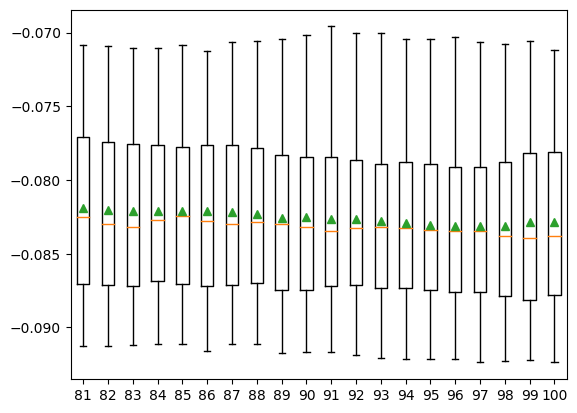

In [109]:
# compare different numbers of features selected using mutual information
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
# define dataset
X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)
# define number of features to evaluate
num_features = [i for i in range(X.shape[1]-19, X.shape[1]+1)]
# enumerate each number of features
results = list()
for k in num_features:
	# create pipeline
	model = LinearRegression()
	fs = SelectKBest(score_func=mutual_info_regression, k=k)
	pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])
	# evaluate the model
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
	results.append(scores)
	# summarize the results
	print('>%d %.3f (%.3f)' % (k, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=num_features, showmeans=True)
pyplot.show()

- **RepeatedStratifiedKFold places an emphasis on maintaining the original class distribution in each fold, making it suitable for datasets with class imbalance, while RepeatedKFold does not consider class distribution and is more appropriate for well-balanced datasets**

### 3-2- Wrapper Methods:

- Recursive Feature Elimination, or RFE for short, is a popular feature selection algorithm.

- RFE is a wrapper-type feature selection algorithm. This means that a different machine learning algorithm is given and used in the core of the method, is wrapped by RFE, and used to help select features. This is in contrast to filter-based feature selections that score each feature and select those features with the largest (or smallest) score.

- Technically, RFE is a wrapper-style feature selection algorithm that also uses filter-based feature selection internally.

- RFE works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains.

- This is achieved by fitting the given machine learning algorithm used in the core of the model, ranking features by importance, discarding the least important features, and re-fitting the model. This process is repeated until a specified number of features remains.

- Features are scored either using the provided machine learning model (e.g. some algorithms like decision trees offer importance scores) or by using a statistical method.

- There are two important configuration options when using RFE: the choice in the number of features to select and the choice of the algorithm used to help choose features. Both of these hyperparameters can be explored, although the performance of the method is not strongly dependent on these hyperparameters being configured well.

- The algorithm used in RFE does not have to be the algorithm that is fit on the selected features; different algorithms can be used.

- Once configured, the class must be fit on a training dataset to select the features by calling the fit() function. After the class is fit, the choice of input variables can be seen via the “support_” attribute that provides a True or False for each input variable.


### RFE for Classification

In [111]:
# evaluate RFE for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# create pipeline
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

## For prediction
pipeline.fit(X, y)
# make a prediction for one example
data = [[2.56999479,-0.13019997,3.16075093,-4.35936352,-1.61271951,-1.39352057,-2.48924933,-1.93094078,3.26130366,2.05692145]]
yhat = pipeline.predict(data)
print('Predicted Class: %d' % (yhat))

Accuracy: 0.884 (0.030)
Predicted Class: 1


### RFE for Regression
- We will report the mean absolute error (MAE) of the model across all repeats and folds. The scikit-learn library makes the MAE negative so that it is maximized instead of minimized. This means that larger negative MAE are better and a perfect model has a MAE of 0.

In [112]:
# evaluate RFE for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# create pipeline
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=5)
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on all available data
pipeline.fit(X, y)
# make a prediction for one example
data = [[-2.02220122,0.31563495,0.82797464,-0.30620401,0.16003707,-1.44411381,0.87616892,-0.50446586,0.23009474,0.76201118]]
yhat = pipeline.predict(data)
print('Predicted: %.3f' % (yhat))

MAE: -27.240 (2.672)
Predicted: -84.288


### Automatically Select the Number of Features

- It is also possible to automatically select the number of features chosen by RFE.

- This can be achieved by performing cross-validation evaluation of different numbers of features as we did in the previous section and automatically selecting the number of features that resulted in the best mean score.

- The RFECV class implements this for us.

- The RFECV is configured just like the RFE class regarding the choice of the algorithm that is wrapped. Additionally, the minimum number of features to be considered can be specified via the “min_features_to_select” argument (defaults to 1) and we can also specify the type of cross-validation and scoring to use via the “cv” (defaults to 5) and “scoring” arguments (uses accuracy for classification).

In [114]:
# automatically select the number of features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# create pipeline
rfe = RFECV(estimator=DecisionTreeClassifier())
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.890 (0.029)


### Which Features Were Selected

- When using RFE, we may be interested to know which features were selected and which were removed.

- This can be achieved by reviewing the attributes of the fit RFE object (or fit RFECV object). The “support_” attribute reports true or false as to which features in order of column index were included and the “ranking_” attribute reports the relative ranking of features in the same order.

In [115]:
# report which features were selected by RFE
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
# fit RFE
rfe.fit(X, y)
# summarize all features
for i in range(X.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 6.000
Column: 1, Selected False, Rank: 4.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected False, Rank: 5.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected False, Rank: 3.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected False, Rank: 2.000


### 3-3- Embedded Methods:

### Feature Importance

- Feature importance refers to a class of techniques for assigning scores to input features to a predictive model that indicates the relative importance of each feature when making a prediction.

- Feature importance scores can provide insight into the dataset. The relative scores can highlight which features may be most relevant to the target, and the converse, which features are the least relevant.

- Feature importance can be used to improve a predictive model. This can be achieved by using the importance scores to select those features to delete (lowest scores) or those features to keep (highest scores). 

##### Coefficients as Feature Importance

- Linear machine learning algorithms fit a model where the prediction is the weighted sum of the input values.

- Examples include linear regression, logistic regression, and extensions that add regularization, such as ridge regression and the elastic net.

- All of these algorithms find a set of coefficients to use in the weighted sum in order to make a prediction. These coefficients can be used directly as a crude type of feature importance score.


Feature: 0, Score: -0.00000
Feature: 1, Score: 12.44483
Feature: 2, Score: -0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 93.32225
Feature: 5, Score: 86.50811
Feature: 6, Score: 26.74607
Feature: 7, Score: 3.28535
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000


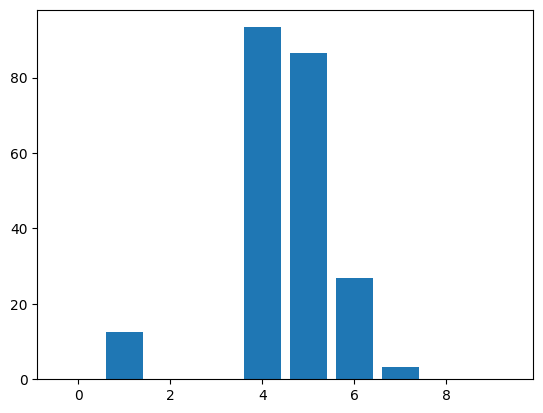

In [116]:
# linear regression feature importance
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = LinearRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#### Decision Tree Feature Importance

- Decision tree algorithms like classification and regression trees (CART) offer importance scores based on the reduction in the criterion used to select split points, like Gini or entropy.

- This same approach can be used for ensembles of decision trees, such as the random forest and stochastic gradient boosting algorithms.

Feature: 0, Score: 0.00265
Feature: 1, Score: 0.00523
Feature: 2, Score: 0.00143
Feature: 3, Score: 0.00192
Feature: 4, Score: 0.51739
Feature: 5, Score: 0.43850
Feature: 6, Score: 0.02665
Feature: 7, Score: 0.00249
Feature: 8, Score: 0.00280
Feature: 9, Score: 0.00095


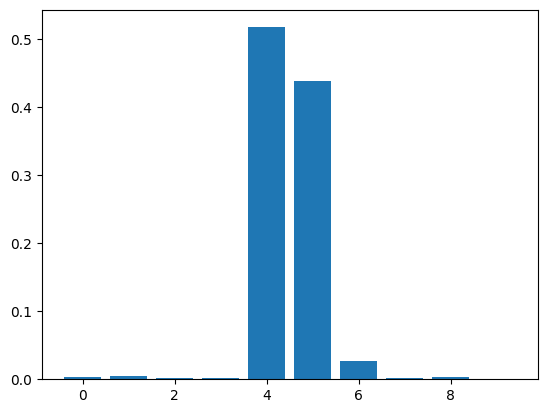

In [117]:
# decision tree for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot
# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = DecisionTreeRegressor()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Random Forest Feature Importance

- We can use the Random Forest algorithm for feature importance implemented in scikit-learn as the RandomForestRegressor and RandomForestClassifier classes.

- After being fit, the model provides a feature_importances_ property that can be accessed to retrieve the relative importance scores for each input feature.

Feature: 0, Score: 0.00281
Feature: 1, Score: 0.00515
Feature: 2, Score: 0.00290
Feature: 3, Score: 0.00278
Feature: 4, Score: 0.52555
Feature: 5, Score: 0.42584
Feature: 6, Score: 0.02628
Feature: 7, Score: 0.00285
Feature: 8, Score: 0.00315
Feature: 9, Score: 0.00268


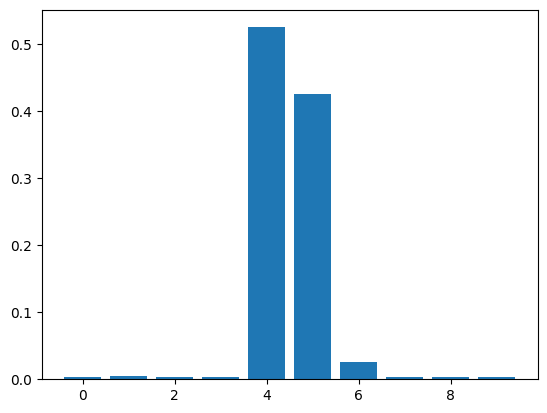

In [118]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = RandomForestRegressor()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### XGBoost Feature Importance

- XGBoost is a library that provides an efficient and effective implementation of the stochastic gradient boosting algorithm.

- This algorithm can be used with scikit-learn via the XGBRegressor and XGBClassifier classes.

- After being fit, the model provides a feature_importances_ property that can be accessed to retrieve the relative importance scores for each input feature.

- This algorithm is also provided via scikit-learn via the GradientBoostingClassifier and GradientBoostingRegressor classes and the same approach to feature selection can be used.

#### XGBoost Regression Feature Importance

- The complete example of fitting a XGBRegressor and summarizing the calculated feature importance scores is listed below.


Feature: 0, Score: 0.00039
Feature: 1, Score: 0.00583
Feature: 2, Score: 0.00112
Feature: 3, Score: 0.00129
Feature: 4, Score: 0.49502
Feature: 5, Score: 0.46443
Feature: 6, Score: 0.02951
Feature: 7, Score: 0.00086
Feature: 8, Score: 0.00075
Feature: 9, Score: 0.00079


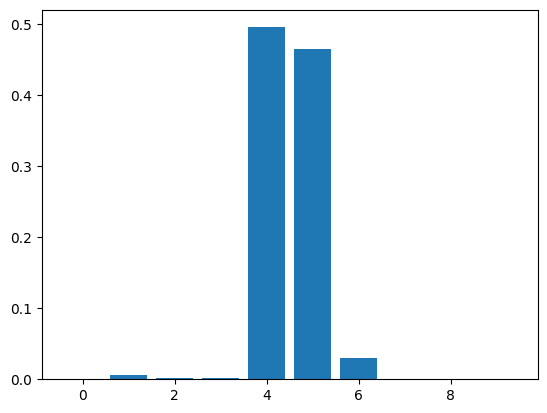

In [119]:
# xgboost for feature importance on a regression problem
from sklearn.datasets import make_regression
from xgboost import XGBRegressor
from matplotlib import pyplot
# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = XGBRegressor()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Permutation Feature Importance

- Permutation feature importance is a technique for calculating relative importance scores that is independent of the model used.

permutation Feature Importance is a technique used in machine learning and feature selection to assess the importance of individual features (variables) in a predictive model. It helps determine how much a model's performance would degrade if the values of a specific feature were randomly shuffled, effectively removing any meaningful relationship between that feature and the target variable.

Here's how it works:

    - Train a machine learning model on your dataset, using all the features of interest.
    - After the model is trained, select one feature you want to evaluate for importance.
    - Permute (shuffle) the values of that selected feature while keeping all other features unchanged. Essentially, you're breaking the connection between the selected feature and the target variable.
    - Use the permuted dataset to make predictions using your trained model.
    - Measure the performance metric of interest (e.g., accuracy, F1 score, mean squared error) on this permuted dataset. This represents the "importance score" for the selected feature.

The idea behind Permutation Feature Importance is that if a feature is essential for the model's performance, permuting its values should result in a significant drop in performance. Conversely, if a feature is not important, permuting it should have a minimal impact on model performance.

#### Permutation Feature Importance for Regression

- The complete example of fitting a KNeighborsRegressor and summarizing the calculated permutation feature importance scores is listed below.

Feature: 0, Score: 132.06211
Feature: 1, Score: 298.40801
Feature: 2, Score: 176.92136
Feature: 3, Score: 22.10700
Feature: 4, Score: 9703.90458
Feature: 5, Score: 8164.34703
Feature: 6, Score: 938.58749
Feature: 7, Score: 128.78456
Feature: 8, Score: 113.86673
Feature: 9, Score: 97.66435


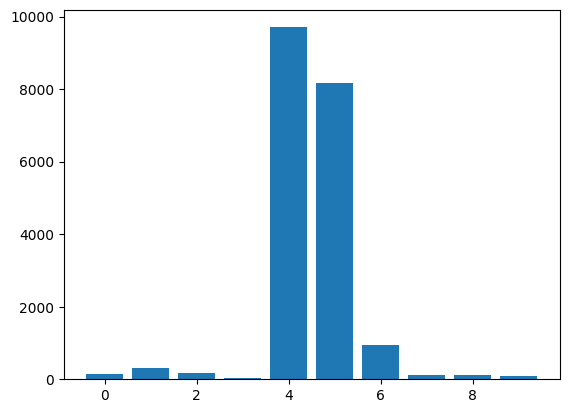

In [120]:
# permutation feature importance with knn for regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = KNeighborsRegressor()
# fit the model
model.fit(X, y)
# perform permutation importance
results = permutation_importance(model, X, y, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Feature Selection with Importance

- Feature importance scores can be used to help interpret the data, but they can also be used directly to help rank and select features that are most useful to a predictive model.

- We could use any of the feature importance scores explored above, but in this case we will use the feature importance scores provided by random forest.

- We can use the SelectFromModel class to define both the model we wish to calculate importance scores, RandomForestClassifier in this case, and the number of features to select, 5 in this case.

In [121]:
# evaluation of a model using 5 features chosen with random forest importance
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select a subset of features
	fs = SelectFromModel(RandomForestClassifier(n_estimators=1000), max_features=5)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# define the dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# fit the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train_fs, y_train)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 84.55



### 3-4- Dimensionality Reduction

- The number of input features for a dataset may be considered the dimensionality of the data.

- The problem is, the more dimensions this space has (e.g. the more input variables), the more likely it is that the dataset represents a very sparse and likely unrepresentative sampling of that space. This is referred to as the curse of dimensionality.

- This motivates feature selection, although an alternative to feature selection is to create a projection of the data into a lower-dimensional space that still preserves the most important properties of the original data.

- The most common approach to dimensionality reduction is to use a matrix factorization technique:

    - Principal Component Analysis (PCA)
    - Singular Value Decomposition (SVD)
    
- The main impact of these techniques is that they remove linear dependencies between input variables, e.g. correlated variables.

### Worked Example of PCA for Dimensionality Reduction

- First, we can use the make_classification() function to create a synthetic binary classification problem with 1,000 examples and 20 input features, 15 inputs of which are meaningful.

- Next, we can use dimensionality reduction on this dataset while fitting a logistic regression model.

- We will use a Pipeline where the first step performs the PCA transform and selects the 10 most important dimensions or components, then fits a logistic regression model on these features. We don’t need to normalize the variables on this dataset, as all variables have the same scale by design.

- The pipeline will be evaluated using repeated stratified cross-validation with three repeats and 10 folds per repeat. Performance is presented as the mean classification accuracy.

In [122]:
# evaluate pca with logistic regression algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
# define the pipeline
steps = [('pca', PCA(n_components=10)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.816 (0.034)


- A better approach is to evaluate the same transform and model with different numbers of input features and choose the number of features (amount of dimensionality reduction) that results in the best average performance.

>1 0.542 (0.048)
>2 0.713 (0.048)
>3 0.720 (0.053)
>4 0.723 (0.051)
>5 0.725 (0.052)
>6 0.730 (0.046)
>7 0.805 (0.036)
>8 0.800 (0.037)
>9 0.814 (0.036)
>10 0.816 (0.034)
>11 0.819 (0.035)
>12 0.819 (0.038)
>13 0.819 (0.035)
>14 0.853 (0.029)
>15 0.865 (0.027)
>16 0.865 (0.027)
>17 0.865 (0.027)
>18 0.865 (0.027)
>19 0.865 (0.027)
>20 0.865 (0.027)


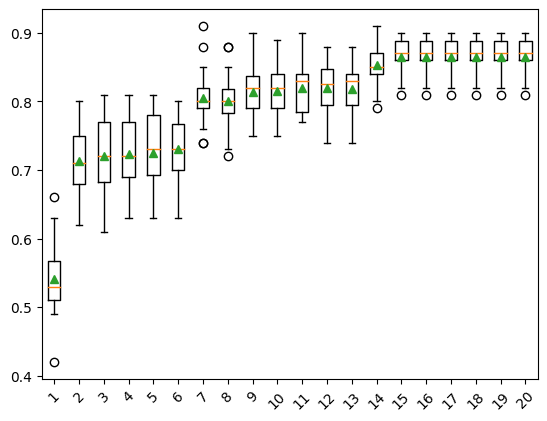

In [124]:
# compare pca number of components with logistic regression algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(1,21):
		steps = [('pca', PCA(n_components=i)), ('m', LogisticRegression())]
		models[str(i)] = Pipeline(steps=steps)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

- We may choose to use a PCA transform and logistic regression model combination as our final model.

- This involves fitting the Pipeline on all available data and using the pipeline to make predictions on new data. Importantly, the same transform must be performed on this new data, which is handled automatically via the Pipeline.

In [125]:
# make predictions using pca with logistic regression
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
# define the model
steps = [('pca', PCA(n_components=15)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)
# fit the model on the whole dataset
model.fit(X, y)
# make a single prediction
row = [[0.2929949,-4.21223056,-1.288332,-2.17849815,-0.64527665,2.58097719,0.28422388,-7.1827928,-1.91211104,2.73729512,0.81395695,3.96973717,-2.66939799,3.34692332,4.19791821,0.99990998,-0.30201875,-4.43170633,-2.82646737,0.44916808]]
yhat = model.predict(row)
print('Predicted Class: %d' % yhat[0])

Predicted Class: 1
